# Main notebook for simulation experiments

## Imports

In [72]:
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
import coclusterSVD as ccSVD
import bicluster as bc
import submatrix as sm
import importlib 

np.set_printoptions(precision=3, suppress=True, linewidth=100)

def generate(seed, num_bicluster, num_pool, M, N, m, n):
    # psedo random vector with fixed seed, ori(0), ori(1), ... ori(num_bicluster-1)
    ori = np.random.RandomState(seed=seed).rand(num_bicluster, num_pool)

    # scale = np.random.RandomState(seed+2).rand(num_bicluster)

    # p is a list, p[i] is a n[i]-length vector, as the base of bicluster i
    p = []
    for i in range(num_bicluster):
        p.append(ori[i][:n[i]])

    for i in range(num_bicluster):
        assert len(p[i]) == n[i]

    A = np.zeros((M, N))

    # A(0:n(0), 0:m(0)) = p(0)
    # A(n(0):n(0)+n(1), 0:m(1)) = p(1)
    # ...

    startx = starty = 0
    label_matrix = np.zeros((M, N)) # value is the label of bicluster
    for i in range(num_bicluster):
        for j in range(m[i]):
            A[startx:startx+n[i], starty+j] = p[i] * np.random.RandomState(i*2000 + j).rand()
            label_matrix[startx:startx+n[i], starty+j] = i
        startx += n[i]
        starty += m[i]

    # show A as a heatmap
    # plt.imshow(A, cmap='hot', interpolation='nearest')
    # plt.show()

    # permutation of M and N
    permx = np.random.RandomState(seed).permutation(M)
    permy = np.random.RandomState(seed+1).permutation(N)

    # print permx and permy
    # print('permx: ', permx)
    # print('permy: ', permy)

    # permute A
    B = A[permx, :]
    B = B[:, permy]

    label_matrix = label_matrix[permx, :]
    label_matrix = label_matrix[:, permy]

    # B = A + rand * 0.1 * average(A)
    # B = B + np.random.RandomState(seed).rand(M, N) * 0.01 * np.mean(A)

    # show B as a heatmap

    return B, permx, permy, A, label_matrix


## Generate Big Matrix ($M \times N$)

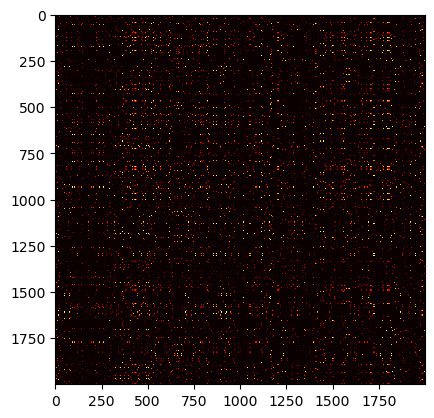

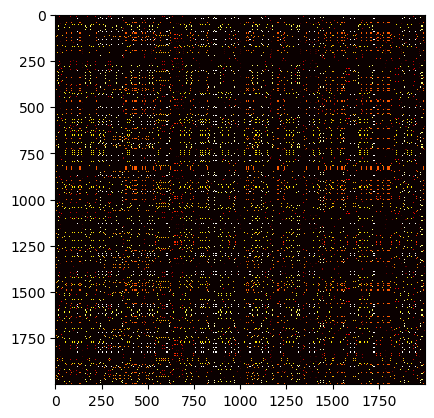

In [73]:
seed = 42
num_pool = 200 # as random pool for bases of biclusters
# num_upper_bound = 20 # upper bound of number of biclusters
# num_bicluster = np.random.RandomState(seed+1).randint(1, num_upper_bound, 1)[0] # number of biclusters
num_bicluster = 15
# random n(0) n(1) n(2) ... n(num_bicluster-1) as the length of each bicluster base vector
n = np.random.RandomState(seed=seed).randint(
    num_pool/5, num_pool, num_bicluster)


# m is the height of biclusters
m = np.random.RandomState(
    seed=seed+1).randint(num_pool/5, num_pool, num_bicluster)
# m = np.ones(num_bicluster, dtype=int) * 1000
# n = np.ones(num_bicluster, dtype=int) * 1000

M = 2000
N = 2000
B, permx, permy, A, labelMatrix = generate(
        seed=seed, num_pool=num_pool, num_bicluster=num_bicluster, M=M, N=N, m=m, n=n
    )

# print('permx: ', permx)
# print('permy: ', permy)

plt.imshow(B, cmap='hot', interpolation='nearest')
plt.show()

plt.imshow(labelMatrix, cmap='hot', interpolation='nearest')
plt.show()

## Generate submatrix list (and labelMatList)

(500, 500)


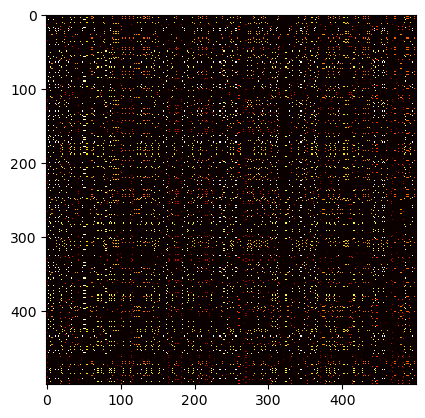

In [74]:
partition : int = 4

sizex = M // partition
sizey = N // partition

importlib.reload(sm)
subMatList = []
labelMatList = []
for i in range(partition):
    for j in range(partition):
        subMatList.append(sm.submatrix(B[i*sizex:(i+1)*sizex, j*sizey:(j+1)*sizey], i*sizex, j*sizey))
        labelMatList.append(sm.submatrix(labelMatrix[i*sizex:(i+1)*sizex, j*sizey:(j+1)*sizey], i*sizex, j*sizey))

print(labelMatList[0].matrix.shape)
plt.imshow(labelMatList[0].matrix, cmap='hot', interpolation='nearest')
plt.show()


## Coclustering on each submatrix

In [94]:
importlib.reload(ccSVD)
importlib.reload(bc)
from joblib import Parallel, delayed
# ans = ccSVD.coclusterAtom(testB, tor=10e-2, k = 15)

# biclusterList = []
# for item in subMatList:
# for item in labelMatList:
    # concat the biclusterList
#     biclusterList += ccSVD.coclusterAtom(X=item, tor=10e-5, k = 15, M=M, N=N)

result = Parallel(n_jobs=-1)(delayed(ccSVD.coclusterAtom)(X=item, tor=10e-5, k = 15, M=M, N=N) for item in labelMatList)
biclusterList = []
for item in result:
    biclusterList += item


12332.15s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
12332.33s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
12332.50s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
12332.67s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.00

In [95]:
# show all item in result (<class 'list'>)
print('len(result): ', len(result))
for item in result:
    # print('item type: ', type(item))
    print('item len: ', len(item))

len(result):  16
item len:  14
item len:  14
item len:  14
item len:  14
item len:  14
item len:  14
item len:  14
item len:  14
item len:  14
item len:  14
item len:  14
item len:  14
item len:  14
item len:  14
item len:  14
item len:  14


## research on `result[0]`

In [93]:
testResult = result[0]
print('testResult type: ', type(testResult))

for i in testResult:
    print('i type: ', type(i))
    print('i', i)

testResult type:  <class 'list'>
i type:  <class 'bicluster.bicluster'>
i bicluster(row_idx=array([ True, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.0)
i type:  <class 'bicluster.bicluster'>
i bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.0)
i type:  <class 'bicluster.bicluster'>
i bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([ True, False, False, ..., False, False, False]), score=0.0)
i type:  <class 'bicluster.bicluster'>
i bicluster(row_idx=array([False, False,  True, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.0)
i type:  <class 'bicluster.bicluster'>
i bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.0)
i type:  <class '

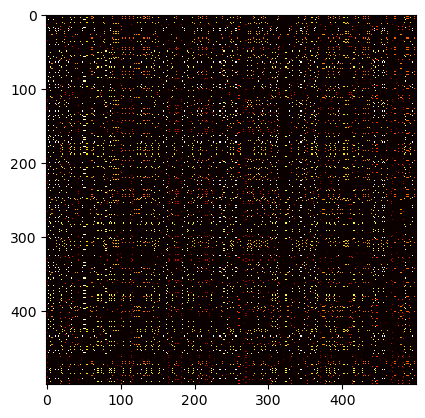

labelZero Matrix:  [[ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  3. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  3. ...  0.  0.  0.]
 [12.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]


In [78]:
plt.imshow(labelMatList[0].matrix, cmap='hot', interpolation='nearest')
plt.show()

print('labelZero Matrix: ', labelMatList[0].matrix)

## Merge coclustering results

In [96]:
# while biclusterList not empty
from coclusterSVD import isBiclusterIntersectGeneral
importlib.reload(ccSVD)
importlib.reload(bc)


count = 0
flag = True # if flag is True, then the item is not merged
while len(biclusterList) > 0:
    count += 1
    item : bc.bicluster = biclusterList.pop(0)
    for item_c in biclusterList:
        # concat the biclusterList
        # if ccSVD.isBiclusterIntersectGeneral(bc1=item, bc2=item_c):
        if True:
            # newRowIdx is OR(rowIdx, rowIdx_c)
            # e.g. rowIdx = [True, False, True], rowIdx_c = [False, True, True], newRowIdx = [True, True, True]
            newRowIdx = np.logical_or(item.row_idx, item_c.row_idx)
            newColIdx = np.logical_or(item.col_idx, item_c.col_idx)
            newScore = ccSVD.score(B, newRowIdx, newColIdx)
            print('newScore: ', newScore)
            # if newScore < item.score + item_c.score or newScore < 0.01:
            if newScore < item.score + item_c.score or newScore < 0.001:
                # replace item_c with new bicluster
                biclusterList.remove(item_c)
                biclusterList.append(bc.bicluster(newRowIdx, newColIdx, newScore))
                count = 0
                flag = False
                break
    if flag:
        biclusterList.append(item)
        flag = True
    if count > 2 * len(biclusterList):
        break
    
print('biclusterList.length: ', len(biclusterList))
            

newScore:  0.36567485049521165
newScore:  0.46793044288256835
newScore:  0.4440918562816526
newScore:  0.4007998451461553
newScore:  0.4763511545613376
newScore:  0.4078926888113462
newScore:  0.4405690030767073
newScore:  0.394663783814617
newScore:  0.3669053466088129
newScore:  0.4175956740426173
newScore:  0.4305980104567254
newScore:  0.3518193941636496
newScore:  0.4284039808251098
newScore:  0.21912767886375073
newScore:  0.43574930121695876
newScore:  0.4419811801829092
newScore:  0.4129735667360793
newScore:  0.46126479163470857
newScore:  0.407828368060577
newScore:  0.44093738430305396
newScore:  0.38980619891990587
newScore:  0.4325604792543323
newScore:  0.4392034492857707
newScore:  0.38399401041514536
newScore:  0.35821756173718244
newScore:  0.36545894944473944
newScore:  0.4201733231213085
newScore:  0.2272273340070876
newScore:  0.44297540511704114
newScore:  0.40880761329904725
newScore:  0.4207023824778874
newScore:  0.4354264720051888
newScore:  0.4044283050190889


In [80]:
# print all length of biclusters
ite = 0
for item in biclusterList:
    print('ite: ', ite)
    print('row length: ', np.sum(item.row_idx))
    # print('row_size: ', item.row_idx.size)
    print('col length: ', np.sum(item.col_idx))
    # print('col_size: ', item.col_idx.size)
    print('score: ', item.score)
    # print('row_idx: ', item.row_idx)
    # print('col_idx: ', item.col_idx)
    print('------------------')
    ite += 1
    

## TestA

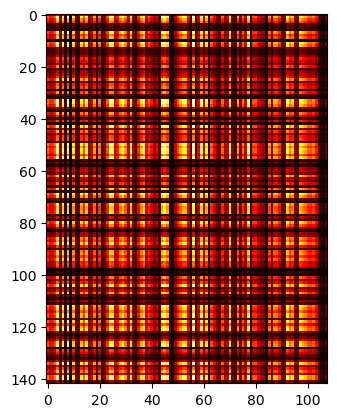

testScore:  0.25059402247221485
testA:  [[0.206 0.156 0.163 0.206 0.362 0.083 0.334 0.029 0.327 0.004]
 [0.522 0.396 0.415 0.524 0.919 0.211 0.849 0.073 0.83  0.01 ]
 [0.402 0.305 0.319 0.403 0.708 0.162 0.654 0.056 0.639 0.008]
 [0.329 0.25  0.261 0.33  0.579 0.133 0.535 0.046 0.523 0.006]
 [0.086 0.065 0.068 0.086 0.151 0.035 0.139 0.012 0.136 0.002]
 [0.086 0.065 0.068 0.086 0.151 0.035 0.139 0.012 0.136 0.002]
 [0.032 0.024 0.025 0.032 0.056 0.013 0.052 0.004 0.051 0.001]
 [0.475 0.361 0.378 0.477 0.838 0.192 0.773 0.066 0.757 0.009]
 [0.33  0.251 0.262 0.331 0.581 0.133 0.537 0.046 0.525 0.006]
 [0.389 0.295 0.309 0.39  0.685 0.157 0.632 0.054 0.618 0.007]]


In [81]:
# cluster1index = permx
testA = A[0:n[0], 0:m[0]]
plt.imshow(testA, cmap='hot', interpolation='nearest')
plt.show()
# testI is all true with shape (n[0],)
# testJ is all true with shape (m[0],)
testI = np.ones(n[0], dtype=bool)
testJ = np.ones(m[0], dtype=bool)

testScore = ccSVD.score(testA, testI, testJ)
print('testScore: ', testScore)

# print 10x10 of testA
print('testA: ', testA[0:10, 0:10])


In [82]:
# m[0]
# n[0]
print('m[0]: ', m[0])
print('n[0]: ', n[0])

# find range(0, n[0]) from permx and save it to IDX_I_one
# find range(0, m[0]) from permy and save it to IDX_J_one

IDX_I_one = permx[0:n[0]]
IDX_J_one = permy[0:m[0]]

# show limited to M // partition * N // partition submatrix
IDX_I_one = IDX_I_one[IDX_I_one < M // partition]
IDX_J_one = IDX_J_one[IDX_J_one < N // partition]

print('IDX_I_one: ', IDX_I_one)
print('IDX_J_one: ', IDX_J_one)

m[0]:  108
n[0]:  142
IDX_I_one:  [353  65  56 374 275 128  99  29 450 254 124 251  70 247 212 361 111 383 324 368  69 478 281 210
 297 429 239 256 382 352 494 393 464 366 306]
IDX_J_one:  [305 454 497  91 131 495 384 431 112  82  23  72 404 427 270 195  68]


## Work on one submatrix

### Get the small matrix

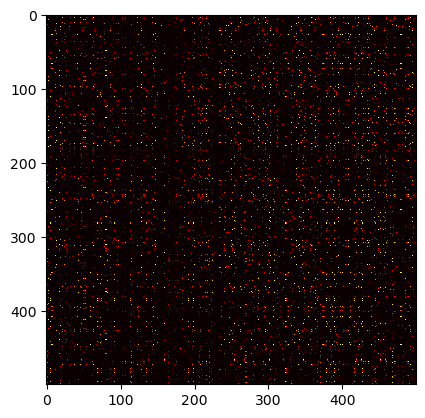

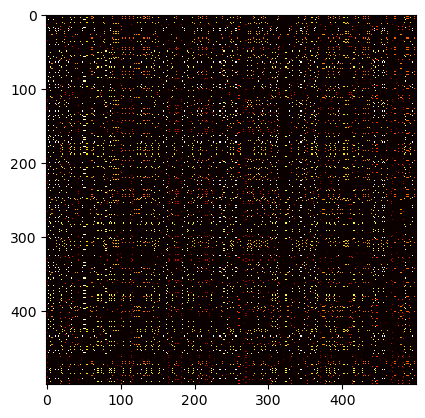

In [83]:
testB = subMatList[0]
testB_label = labelMatList[0]

plt.imshow(testB.matrix, cmap='hot', interpolation='nearest')
plt.show()

plt.imshow(testB_label.matrix, cmap='hot', interpolation='nearest')
plt.show()

In [84]:
ans = ccSVD.coclusterAtom(testB, tor=10e-2, k = 15, M=M, N=N)
print('ans: ', ans)

ans:  [bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.032978881688273454), bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.03094888569280496), bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.04075583806613625), bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.03917286664081199), bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.04951525137957935), bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False,  True, False, ..., False, False, False]), score=0.0236318881630306

## Work on labelMatList[0]

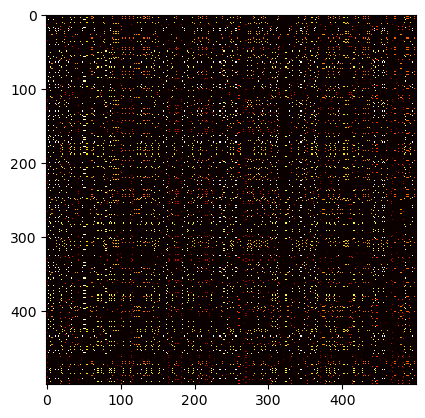

In [85]:
importlib.reload(ccSVD)
importlib.reload(bc)

# imshow B
plt.imshow(labelMatList[0].matrix, cmap='hot', interpolation='nearest')

U, S, Vh = np.linalg.svd(labelMatList[0].matrix, full_matrices=False)
C = np.dot(U, np.diag(S))

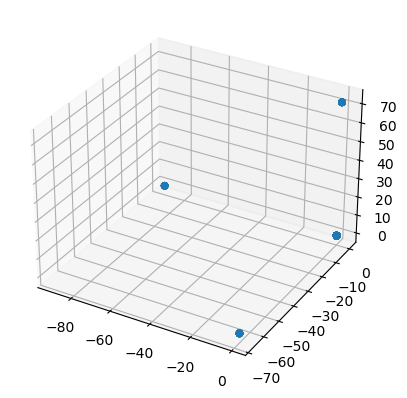

In [86]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

x, y, z = C[:, 0], C[:, 1], C[:, 2]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z)
plt.show()


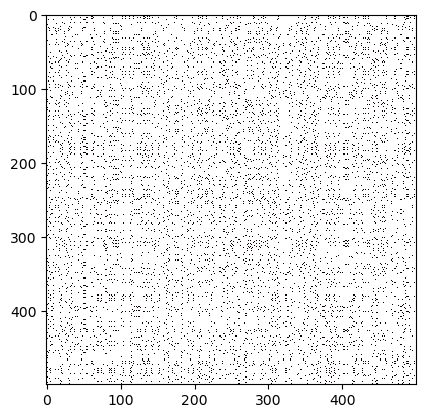

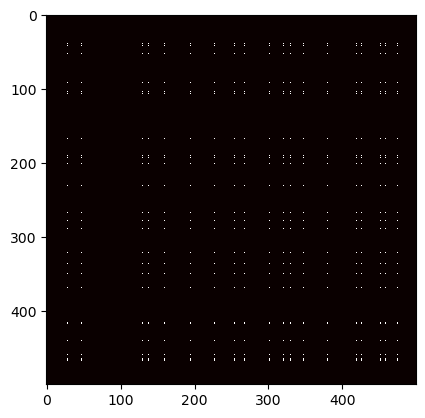

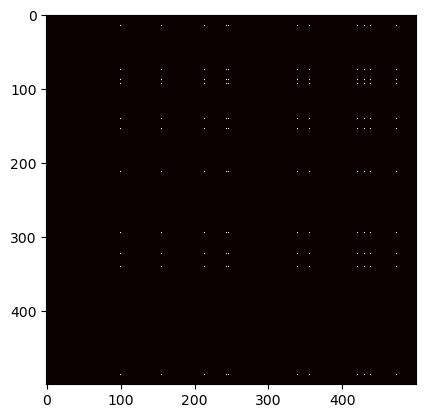

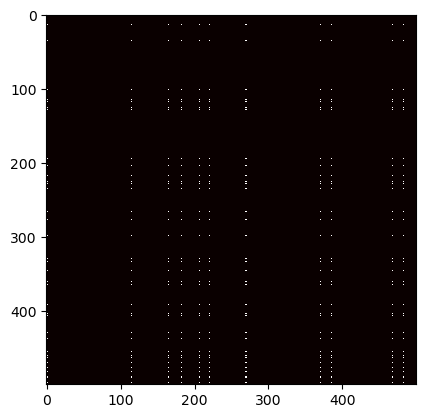

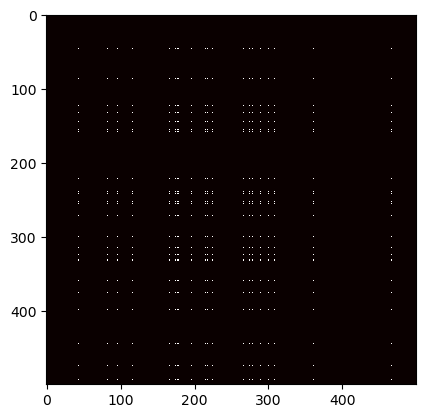

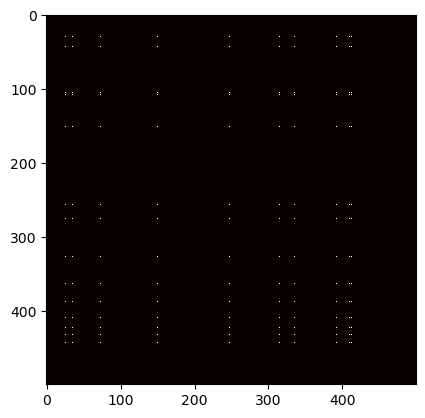

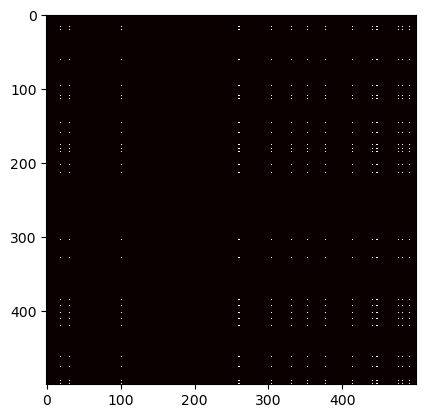

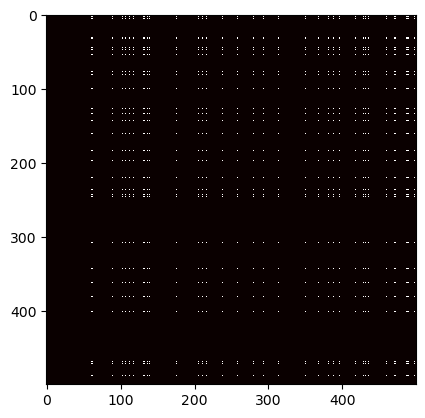

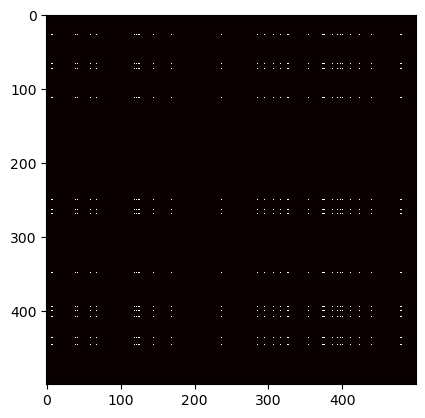

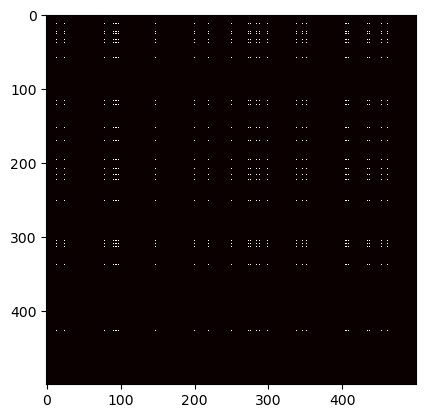

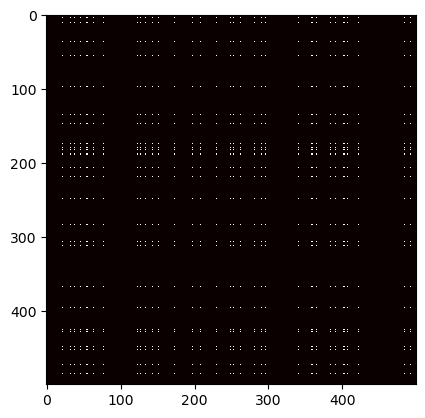

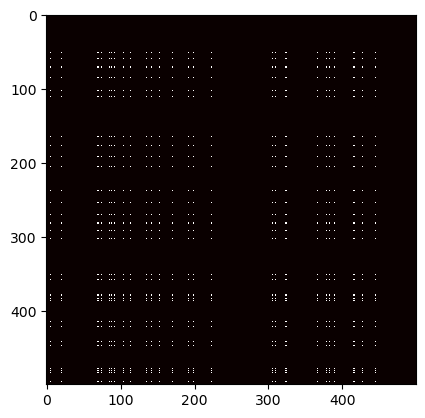

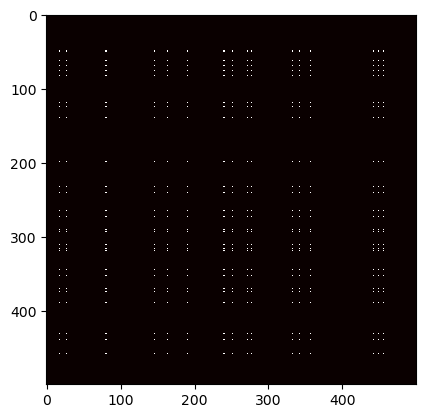

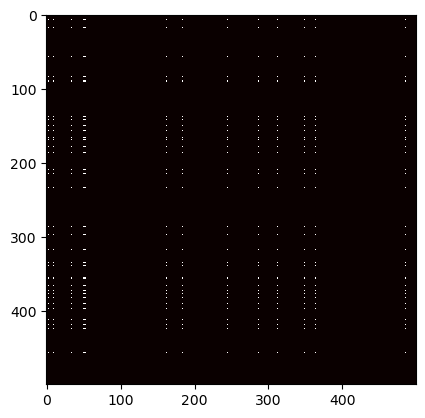

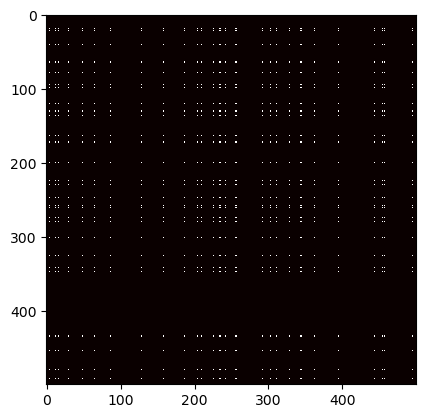

In [87]:
testLabelMat = labelMatList[0]
ansBiList = ccSVD.coclusterAtom(testLabelMat, tor=10e-2, k = 15, M=M, N=N)

# show testLabelMat.matrix == i
for i in range(num_bicluster):
    plt.imshow(testLabelMat.matrix == i, cmap='hot', interpolation='nearest')
    plt.show()


In [88]:
# find testLabelMat.matrix == 1
rowIndOne = np.where(testLabelMat.matrix == 1)[0]
colIndOne = np.where(testLabelMat.matrix == 1)[1]

print('rowIndOne.shape: ', rowIndOne.shape)
print('colIndOne.shape: ', colIndOne.shape)

# matBoolOne means testLabelMat.matrix == 1
matBoolOne = testLabelMat.matrix == 1
rowBoolOne = np.any(matBoolOne, axis=1)
colBoolOne = np.any(matBoolOne, axis=0)

scoreTestOne = ccSVD.score(testLabelMat.matrix, rowBoolOne, colBoolOne)
print('scoreTestOne: ', scoreTestOne)

# show ansBiList
# for item in ansBiList:
#     print('row length: ', np.sum(item.row_idx))
#     print('col length: ', np.sum(item.col_idx))
#     print('score: ', item.score)
#     print('------------------')


rowIndOne.shape:  (864,)
colIndOne.shape:  (864,)
scoreTestOne:  0.0


## testPure is 10x10 one matrix

### generate test matrix and cocluster

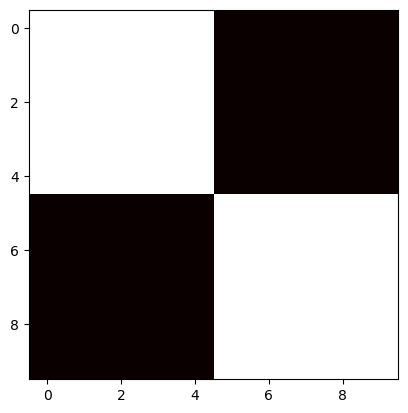

In [89]:
importlib.reload(ccSVD)
import submatrix as sm

testPureMat = np.zeros((10, 10))
testPureMat[0:5, 0:5] = 1
testPureMat[5:10, 5:10] = 1
plt.imshow(testPureMat, cmap='hot', interpolation='nearest')
plt.show()

PureidxI = np.ones(10, dtype=bool)
PureidxJ = np.ones(10, dtype=bool)

pureSub = sm.submatrix(testPureMat, 0, 0)

resultTen = ccSVD.coclusterAtom(pureSub, tor=10e-2, k = 2, M=10, N=10)


### show the cocluster

In [90]:
# print length of resultTen
print('len(resultTen): ', len(resultTen))

for i in range(len(resultTen)):
    print('row length: ', np.sum(resultTen[i].row_idx))
    print('col length: ', np.sum(resultTen[i].col_idx))
    print('score: ', resultTen[i].score)
    print('row_idx: ', resultTen[i].row_idx)
    print('col_idx: ', resultTen[i].col_idx)
    print('------------------')


len(resultTen):  3
row length:  5
col length:  5
score:  0.0
row_idx:  [False False False False False  True  True  True  True  True]
col_idx:  [False False False False False  True  True  True  True  True]
------------------
row length:  5
col length:  5
score:  0.05888502188141542
row_idx:  [ True  True  True  True  True False False False False False]
col_idx:  [False False False False False  True  True  True  True  True]
------------------
row length:  5
col length:  5
score:  0.0
row_idx:  [ True  True  True  True  True False False False False False]
col_idx:  [ True  True  True  True  True False False False False False]
------------------


## SVD on testPureMatm

In [91]:
importlib.reload(ccSVD)
U, S, Vh = np.linalg.svd(testPureMat, full_matrices=False)
resultTen = ccSVD.coclusterAtom(pureSub, tor=10e-3, k = 2, M=10, N=10)
np.allclose(testPureMat, np.dot(U, np.dot(np.diag(S), Vh)))

True